In [ ]:
%matplotlib inline
import matplotlib as pyplot
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

In [2]:
gd2_df = pd.read_pickle('data/gd2_df.pkl')
covers_df = pd.read_pickle('data/covers_df.pkl')
os_df = pd.read_pickle('data/os_df.pkl')

In [3]:
df = pd.merge(gd2_df, covers_df,
              left_on=['gid', 'team_code'],
              right_on=['gid', 'team'])

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['season'] = df['date'].dt.year
df['weekday'] = df['date'].dt.weekday

df = df.sort_values(['team_code', 'date'])

df[['batting_r', 'other_team_runs']] = df[['batting_r', 'other_team_runs']].astype(int)
df[['wins', 'starter_w']] = df[['wins', 'starter_w']].astype(int)
df['starter_game_score'] = df['starter_game_score'].astype(float)

df['run_diff'] = df['batting_r'] - df['other_team_runs']

In [5]:
df['game_as_favorite'] = ((df['us_line'] < 0) ).astype(int)
df['game_as_underdog'] = ((df['us_line'] >= 0)).astype(int)

df['win_as_favorite'] = ((df['us_line'] < 0) & (df['batting_r'] > df['other_team_runs'])).astype(int)
df['win_as_underdog'] = ((df['us_line'] >= 0) & (df['batting_r'] > df['other_team_runs'])).astype(int)

In [6]:
game_cols = ['gid', 'status_ind', 'date', 'weekday', 'clouds', 'hp_ump', 'temp', 'wind_dir', 'wind_speed',
             'over_under', 'league', 'away_time_diff', 'division_game', 'game_type']
game_df = df[game_cols].drop_duplicates('gid')

In [7]:
for i in ['home', 'away']:
    col = '{}_money_line'.format(i)
    indexer = (os_df[col] != '') & (os_df[col].notnull())
    os_df[col] = os_df[col].loc[indexer].astype(int)

col = 'home_spread'
indexer = (os_df[col] != '') & (os_df[col].notnull())
os_df[col] = os_df[col].loc[indexer].astype(float)

os_keep_re = '.'
os_df = os_df.filter(regex=os_keep_re)
game_df = pd.merge(game_df, os_df, on='gid', how='left')

In [8]:
team_group = ['season', 'team_code']
shift_cols = ['batting_avg', 'batting_obp', 'batting_ops', 'pitching_era', 'wins', 'loss']

team_df = (df.groupby(team_group)[shift_cols]
             .transform(lambda x: x.shift())).astype(float)

team_df['team_runs'] = df['batting_r']

team_df['team_win_pct'] = team_df['wins'] / (team_df['wins'] + team_df['loss'])

team_df['team_last_5_win_pct']  = (df.groupby(team_group)['wins']
                                     .transform(lambda x: (x.shift() - x.shift(6)) / 5))

team_df['season_complete_pct'] = (team_df['wins'] + team_df['loss']) / 162

no_shift_cols = ['us_line', 'decimal_line']
team_df[no_shift_cols] = df[no_shift_cols]

gb_cols = ['games_back', 'games_back_wildcard']
team_df[gb_cols] = (df.groupby(team_group)[gb_cols]
                      .transform(lambda x: x.shift().ffill()))

team_df['season_win_pct_as_favorite'] = (df.groupby(team_group)['win_as_favorite']
                                           .transform(lambda x: x.shift().cumsum()) /
                                         df.groupby(team_group)['game_as_favorite']
                                           .transform(lambda x: x.shift().cumsum()))

team_df['season_win_pct_as_underdog'] = (df.groupby(team_group)['win_as_underdog']
                                           .transform(lambda x: x.shift().cumsum()) /
                                         df.groupby(team_group)['game_as_underdog']
                                           .transform(lambda x: x.shift().cumsum()))

In [9]:
oth_group = ['season', 'team_code', 'other_team_code']

oth_df = (df.groupby(oth_group)['batting_r', 'other_team_runs']
            .transform(lambda x: x.astype(int).shift()))

oth_df = pd.concat([df[oth_group], oth_df], axis=1)

oth_df['oth_win'] = (oth_df['batting_r'] > oth_df['other_team_runs']).astype(int)

team_df['season_win_pct_against_other_team'] = (oth_df.groupby(oth_group)['oth_win']
                                                      .transform(lambda x: x.expanding().mean()))

In [10]:
starter_group = ['season', 'team_code', 'starter_name_display_first_last']
starter_cols = ['starter_w', 'starter_l', 'starter_s_bb', 'starter_s_ip',
                'starter_s_h', 'starter_s_so', 'starter_era']

starter_df = (df.groupby(starter_group)[starter_cols]
                .transform(lambda x: x.shift())).astype(float)

starter_df['starter_s_hr'] = (df.groupby(starter_group)['starter_hr']
                                .transform(lambda x: x.astype(int).shift().cumsum()))

starter_df['starter_s_game_score'] = (df.groupby(starter_group)['starter_game_score']
                                        .transform(lambda x: x.shift().expanding().mean()))

starter_df['starter_hr_ip'] = starter_df['starter_s_hr'] / starter_df['starter_s_ip']

starter_df['starter_win_pct'] = (starter_df['starter_w'] / 
                                 (starter_df['starter_w'] + starter_df['starter_l']))

starter_df['starter_last_5_win_pct']  = (df.groupby(starter_group)['starter_w']
                                          .transform(lambda x: (x.shift() - x.shift(6)) / 5))

starter_df['starter_s_whip'] = ((starter_df['starter_s_bb'] + starter_df['starter_s_h']) /
                                starter_df['starter_s_ip'])

starter_df['starter_s_soip'] = (starter_df['starter_s_so'])/ starter_df['starter_s_ip']

In [11]:
add_cols = ['team_code', 'starter_name_display_first_last']

hix = (df['home_away'] == 'home')
home_df = pd.concat([df.loc[hix, add_cols], team_df[hix], starter_df[hix]], axis=1)
home_df = home_df.rename(columns=lambda x: 'home_{}'.format(x))
home_df = pd.concat([df.loc[hix, 'gid'], home_df], axis=1)

aix = (df['home_away'] == 'away')
away_df = pd.concat([df.loc[aix, add_cols], team_df[aix], starter_df[aix]], axis=1)
away_df = away_df.rename(columns=lambda x: 'away_{}'.format(x))
away_df = pd.concat([df.loc[aix, 'gid'], away_df], axis=1)

In [12]:
train_df = pd.merge(game_df, pd.merge(home_df, away_df, on='gid'), on='gid')
# train_df = train_df.fillna(0)

In [13]:
ignore = ['gid', 'status_ind', 'date', 'home_team_code', 'home_wins', 'home_loss',
    'home_starter_name_display_first_last', 'home_starter_w',
    'home_starter_l', 'home_starter_s_bb', 'home_starter_s_ip',
    'home_starter_s_h', 'home_starter_s_so', 'home_starter_s_hr',
    'away_team_code', 'away_wins', 'away_loss', 'away_starter_name_display_first_last',
    'away_starter_w', 'away_starter_l', 'away_starter_s_bb', 'away_starter_s_ip',
    'away_starter_s_h', 'away_starter_s_so', 'away_starter_s_hr', 'home_team_runs', 'away_team_runs',
    'event_id', 'event_date', 'home_abbreviation', 'away_abbreviation']

# ignore = ignore + ['home_us_line', 'home_decimal_line', 'away_us_line', 'away_decimal_line']
# ignore = ignore + ['home_season_win_pct_against_other_team', 'away_season_win_pct_against_other_team']

cats = ['weekday', 'clouds', 'hp_ump', 'wind_dir', 'league', 'game_type']
num = list(set(train_df.columns) - set(cats + ignore))

In [14]:
x = pd.concat([train_df[num].astype(float), pd.get_dummies(train_df[cats])], axis=1)

In [15]:
y = (train_df['home_team_runs'].astype(int) > train_df['away_team_runs'].astype(int)).astype(int)

In [16]:
kf = KFold(n_splits=10, shuffle=False)

In [17]:
dtrain = xgb.DMatrix(x, label=y, feature_names=x.columns)

In [18]:
param = {
    'max_depth': 2,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'reg_alpha': 1,
    'reg_lambda': 1,
    'min_child_weight': 5
}
history = xgb.cv(params=param, dtrain=dtrain, num_boost_round=100, folds=kf.split(x),
                 metrics=['auc'], verbose_eval=1,
                 early_stopping_rounds=5)

[0]	train-auc:0.588601+0.00298337	test-auc:0.58271+0.0171048
[1]	train-auc:0.59226+0.00276096	test-auc:0.587983+0.0172985
[2]	train-auc:0.594927+0.00322099	test-auc:0.588351+0.0174199
[3]	train-auc:0.597025+0.00295707	test-auc:0.590188+0.0170338
[4]	train-auc:0.598205+0.00301169	test-auc:0.591279+0.0168032
[5]	train-auc:0.59935+0.00257737	test-auc:0.592684+0.0169563
[6]	train-auc:0.600417+0.00212455	test-auc:0.593191+0.0175326
[7]	train-auc:0.601945+0.0021142	test-auc:0.592559+0.0170245
[8]	train-auc:0.603405+0.00175692	test-auc:0.594515+0.0165906
[9]	train-auc:0.60471+0.00182674	test-auc:0.595722+0.0159128
[10]	train-auc:0.605926+0.00186723	test-auc:0.59597+0.0158966
[11]	train-auc:0.606626+0.00184509	test-auc:0.596345+0.0160626
[12]	train-auc:0.607472+0.00144915	test-auc:0.596854+0.0163269
[13]	train-auc:0.608354+0.00151746	test-auc:0.596955+0.0168012
[14]	train-auc:0.609187+0.00147316	test-auc:0.597077+0.0171884
[15]	train-auc:0.610113+0.00141242	test-auc:0.597462+0.0173305
[16]	tra

In [19]:
best_auc = history['test-auc-mean'].max()
best_auc_iter = history['test-auc-mean'].idxmax()
print("""naive accuracy: {}
best test auc: {} on {} boosting iterations""".format(y.mean(),
                                                      best_auc,
                                                      best_auc_iter))

naive accuracy: 0.5356368367789505
best test auc: 0.601361 on 56 boosting iterations


In [20]:
cv_preds = []
for train_ix, test_ix in kf.split(x):
    dtrain_k = xgb.DMatrix(x.iloc[train_ix], label=y.iloc[train_ix], feature_names=x.columns)
    dtest_k =xgb.DMatrix(x.iloc[test_ix], feature_names=x.columns)
    bst = xgb.train(params=param, dtrain=dtrain_k, num_boost_round=best_auc_iter)
    cv_preds.append({'cv_index': test_ix, 'cv_pred': bst.predict(dtest_k)})

In [21]:
cv_df = pd.concat([pd.DataFrame(f) for f in cv_preds], ignore_index=True)
cv_df = cv_df.sort_values('cv_index')
cv_df['pred_class'] = cv_df['cv_pred'].apply(
    lambda x: 1 if x >= 0.5 else 0)
cv_df['home_wins'] = y
cv_df['pred_bin'] = pd.cut(cv_df['cv_pred'], bins=np.arange(0.0, 1.0, 0.1))
cv_df['implied_probability'] = train_df['home_us_line'].apply(
    lambda x: x / (x - 100) if x < 0 else 100/(x+100))
cv_df['line_bin'] = pd.cut(cv_df['implied_probability'], bins=np.arange(0.0, 1.0, 0.1))

print('cv accuracy: {}'.format(accuracy_score(y_pred=cv_df['pred_class'], y_true=y)))
print('cv auc: {}'.format(roc_auc_score(y, cv_df['cv_pred'])))

line_acc = accuracy_score((train_df['home_us_line'] < train_df['away_us_line']).astype(int), y)
line_auc = roc_auc_score(y, cv_df['implied_probability'])
print('line favorite accuracy: {}'.format(line_acc))
print('line favorite auc: {}'.format(line_auc))

pd.concat([cv_df.groupby('pred_bin')['home_wins'].agg(['count', 'mean']),
           cv_df.groupby('line_bin')['home_wins'].agg(['count', 'mean'])], axis=1)

cv accuracy: 0.575755385282637
cv auc: 0.6003091792250048
line favorite accuracy: 0.57329767240133
line favorite auc: 0.5952310246830794


,count,mean,count,mean
"(0.0, 0.1]",0,NaN,0,NaN
"(0.1, 0.2]",0,NaN,0,NaN
"(0.2, 0.3]",58,0.258621,19,0.105263
"(0.3, 0.4]",798,0.362155,573,0.349040
"(0.4, 0.5]",3463,0.455674,3517,0.448678
"(0.5, 0.6]",6600,0.551515,6099,0.546155
"(0.6, 0.7]",2677,0.644378,3233,0.626353
"(0.7, 0.8]",237,0.683544,391,0.695652
"(0.8, 0.9]",1,1.000000,2,1.000000


In [22]:
cv_df = pd.concat([cv_df, 
                   train_df[['home_decimal_line', 'away_decimal_line',
                             'home_us_line', 'away_us_line']]
                  ], axis=1)

In [23]:
cv_df['home_conf'] = cv_df['cv_pred'] * cv_df['home_decimal_line']
cv_df['away_conf'] = (1 - cv_df['cv_pred']) * cv_df['away_decimal_line']
cv_df['bet_conf'] =  np.where(cv_df['home_conf'] > cv_df['away_conf'],
                              cv_df['home_conf'],
                              cv_df['away_conf'])
cv_df['bet_wins'] =  np.where(cv_df['home_conf'] > cv_df['away_conf'],
                              cv_df['home_wins'],
                              1 - cv_df['home_wins'])
cv_df['bet_decimal_line'] =  np.where(cv_df['home_conf'] > cv_df['away_conf'],
                                      cv_df['home_decimal_line'],
                                      cv_df['away_decimal_line'])
cv_df['bet_return'] = cv_df['bet_wins'] * cv_df['bet_decimal_line']
cv_df = cv_df.sort_values('bet_conf', ascending=False)

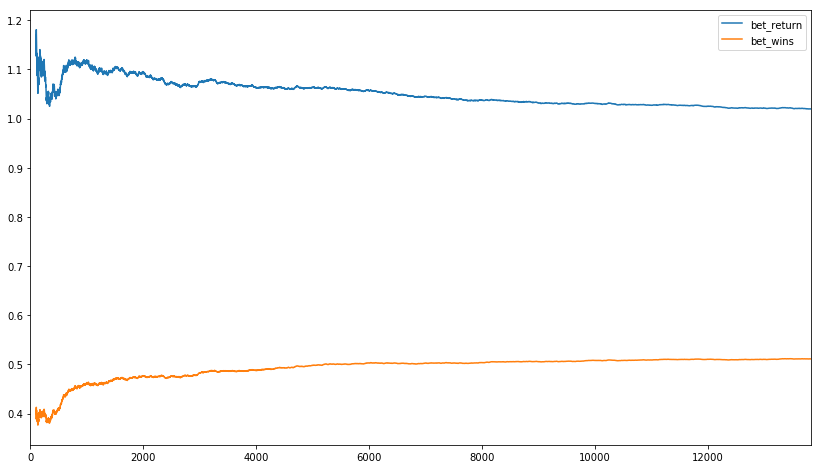

In [24]:
pyplot.rcParams['figure.figsize'] = [14, 8]
cv_df[['bet_return', 'bet_wins']].expanding(100).mean().plot(use_index=False)

In [25]:
bst = xgb.train(params=param, dtrain=dtrain, num_boost_round=best_auc_iter)

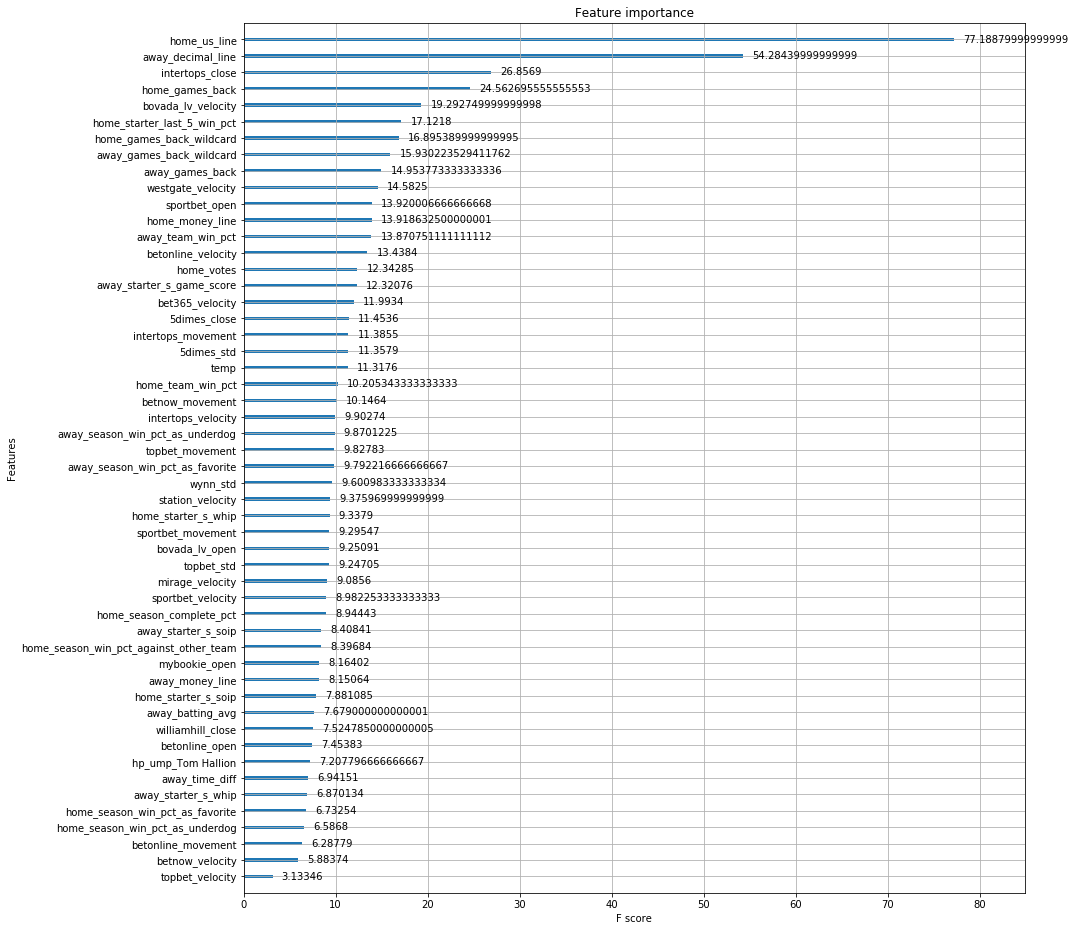

In [26]:
%matplotlib inline
pyplot.rcParams['figure.figsize'] = [14, 16]
xgb.plot_importance(bst, importance_type='gain')